In [ ]:
%%capture
!pip install torchmetrics

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchmetrics import F1Score

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from tqdm.notebook import tqdm

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Представления текстовых данных

Как и в других задачах, первым этапом идёт предобработка и очистка данных. Текстовые данные содержат различный «шум»: знаки препинания, чередование строчных и прописных символов, служебные слова. Текстовые данные необходимо упростить и привести к стандартной форме, которая подходит для используемого алгоритма.

Результатом предобработки станет набор содержательных слов нижнего регистра в начальной форме без знаков препинания.

### Предобработка текста

Стандартная процедура предварительной обработки включает следующие этапы:
- токенизация текста;
- удаление знаков препинания и чисел;
- приведение к нижнему регистру;
- удаление стоп-слов;
- стемминг или лемматизация.

Результатом станет набор содержательных слов нижнего регистра в начальной форме без знаков препинания.


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L09/text_preprocessing.png" width="400" ></center>



Чтобы унифицировать и структурировать текст, нужно разделить его на более мелкие единицы анализа. Процесс разделения больших блоков текста (предложений, абзацев) на более маленькие единицы называется **токенизацией**.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L09/tokenizer.png" width="600" ></center>


### Векторизация текста

Методы машинного обучения работают с числами. Нам нужно найти способы, которые позволят представлять тексты в виде числовых данных.

Если объектом является текст, в качестве признаков выступают слова, которые он содержит. Процесс преобразования текста в числа называется **векторизацией**.

#### Bag-of-words

В этой модели создаётся словарь уникальных слов, а текст представляется в виде вектора размером со словарь с мерой присутствия (числом) таких слов в тексте без какого-либо учета грамматики и порядка слов.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/bag_of_words_representation.png" width="800"></center>

#### TF-IDF

**TF-IDF** — способ численного представления документа, оценивает  **важность слова в контексте документа**. Состоит из двух множителей: **TF** и **IDF**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/tf_idf.png" width="500"></center>




Первая идея **TF-IDF** — **если слово часто встречается в документе, оно важное**. За это отвечает TF.

**TF (term frequency)** — частота вхождения слова в документ, для которого рассчитывается значение:

$$\large \text{TF}(t, d) = \frac{n_t}{\sum_{k}n_k},$$

где $n_t$ — количество повторов слова $t$ в документе $d$,

$\sum_{k}n_k$ — общее количество слов  $t$ в документе $d$ с повторами.

Вторая идея **TF-IDF** — **если слово встречается во многих документах, его ценность снижается**.

Пример: местоимения встречаются в большинстве текстов, но не несут смысловой нагрузки. За это отвечает IDF.

**IDF (inverse document frequency)** — логарифм обратной частоты вхождения слова в документы:

$$\large \text{IDF}(t, D) = \log{\frac{|D|}{|\{d_i \in D| t \in d_i \}|}},$$

где $|D|$ — число документов в коллекции,
$|\{d_i \in D| t \in d_i \}|$ — число документов в коллекции со словом $t$.


Итоговая формула:
$$\large \text{TF-IDF}(t, d, D) = \text{TF}(t,d)⋅\text{IDF}(t, D)$$

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(corpus)

print("Tf-idf dictionary:", vectorizer.get_feature_names_out())
print("Tf-idf dictionary len:", len(vectorizer.get_feature_names_out()))
print("Tf-idf shape:", x.shape)

Tf-idf dictionary: ['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
Tf-idf dictionary len: 9
Tf-idf shape: (4, 9)


**Когда TF-IDF может быть неэффективен:**

1. **Отсутствие семантической информации**: TF-IDF не учитывает семантические связи между словами, что может привести к ограниченной способности понимания смысла текста.

2. **Чувствительность к длине** документа: длинные документы могут иметь более высокие значения TF, даже если ключевые слова встречаются реже. В таких случаях TF-IDF может недооценить важность конкретных слов.

#### Word2Vec

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/w2v_example.png" width="350"></center>




Word2Vec (w2v) — способ представления слов в многомерном векторном пространстве, предложенный в статье [Efficient Estimation of Word Representations in Vector Space (Mikolov et al., 2013)](https://arxiv.org/pdf/1301.3781).

**Векторные представления слов называются эмбеддингами.**

Word2Vec реализуется при помощи полносвязной нейронной сети из двух слоев, которая обрабатывает текст, преобразуя его в числовые “векторизованные” слова. Основной особенностью w2v стало добавление контекста: нейросеть использует информацию о том, какие слова находятся рядом в заданном окне.

Входные данные w2v — это громадный текстовый корпус, из которого на выходе мы получаем пространство векторов, размерность которого обычно достигает сотен, где каждое уникальное слово в корпусе представлено вектором из сгенерированного пространства.

Есть два основных способа реализации Word2Vec: **Skip-Gram** и **CBOW**.

* **Слева** расположен метод **Skip-Gram**, в котором мы передаем какое-то слово нашей нейронной сети и просим ее предположить возможный контекст. $w[i]$ — слово, которое передается на вход и которое находится на позиции $i$ в предложении. На выходе имеем два предшествующих слова и два последующих слова с учетом позиции $i$.

* **Справа — CBOW** (Continuous Bag of Words). Здесь, вместо того, чтобы предугадывать контекстные слова, добавляем их в модель и просим модель предсказать текущее слово.

Фокус состоит в том, что на самом деле никакой обученной нейросети у нас нет. Здесь другая цель — изучить веса скрытого слоя по мере того, как корректируются спрогнозированные веса окружающих слов. Эти веса и есть эмбеддинги.


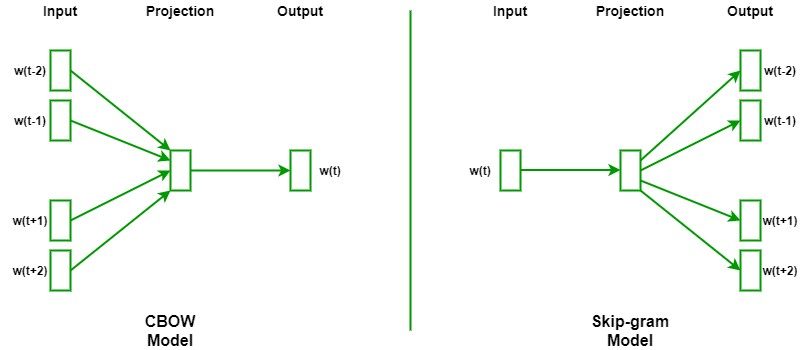

Skip-Gram Матричный вид

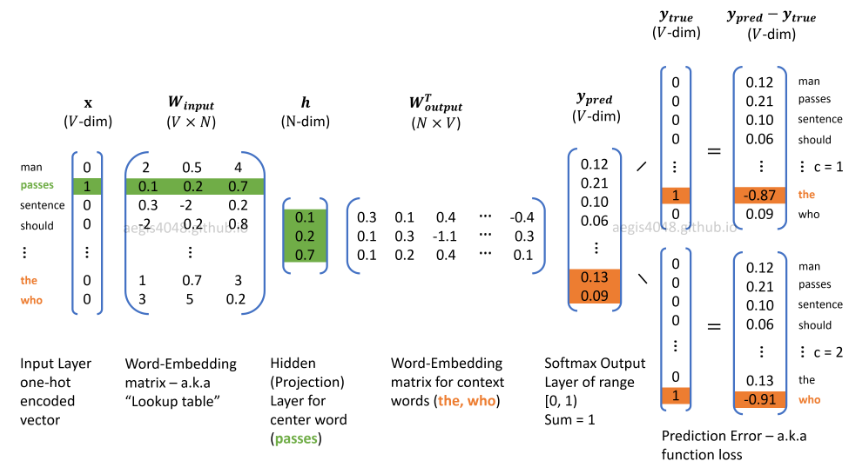

**Данные**

Исходные, "сырые" данные представляют собой предложение

**The quick brown fox jumps over the lazy dog**.

Оставляя за скобками приведение к каноничным формам, создаем датасет так:
1. Проходим по тексту окном заданного размера (в данном случае размер окна 2 означает 2 слова слева и два слова справа от текущего).
2. Относительно текущей позиции формируем пары "текущее слово-соседнее слово" (биграммы).
3. Смещаем окно вправо.

Рассмотрим, как учится сеть для варианта Skip-Gram. На вход сети приходит One-Hot вектор первого слова из биграммы, преобразовывается в пространство эмбеддингов в скрытом слое и поступает на слой SoftMax (размером с весь словарь, т.е. размер входа равен размеру выхода).

По факту нейросеть должна выучить вероятность существования слова *quick* при приходе на вход слова *fox*. При этом можно отметить, что слову *fox* также соответствуют слова *brown, jumps, over*. Обучаясь по кросс-энтропии, последний слой должен выдавать примерно одинаковые вероятности всех этих слов.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/skip_gram_example.png" width="900"></center>


В результате обучения на разнообразных данных сеть выучивает такие распределения, что вектора, соответствующие похожим словам, располагаются близко в новом пространстве, и над ними работают векторные операции.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L09/w2v_example_2.png" width="500"></center>


Разумеется, эти операции не приводят к точному соответствию, однако получаемые вектора оказываются самыми похожими.

Обучение CBOW несколько отличается. На вход сети подаётся $C$ контекстных слов в виде One-Hot, после перемножения с линейным слоем результат усредняется. На выходе слой SoftMax такого же размера.

Иначе векторное представление слов после Word2Vec можно проиллюстрировать так: **(king - man) + woman = queen**

<center><img src="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L09/word2vec_example.png" width="600"></center>

Убедимся в правильности данных арифметических операций с векторными преставлениями `Word2Vec` в коде:

Алгоритм GloVe (Global Vectors) является развитием word2vec. Он использует статистическую информацию о частоте встречаемости слов и фраз в тексте, чтобы улучшить обучение эмбеддингов редких слов. Это достигается за счет корректировки loss-функции, используемой для обучения.

Если мы хотим использовать представления слов GloVe, мы можем воспользоваться библиотекой [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html#documentation)

In [ ]:
import gensim.downloader as api

list(api.info()["models"].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [ ]:
glove = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


Проведем несколько арифметических операций со словами-векторами из `glove`:

In [ ]:
print("Результат операции woman + king - man:")
glove.most_similar(positive=["woman", "king"], negative=["man"])

Результат операции woman + king - man:


[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.631171703338623),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [ ]:
print("Результат операции mother from father + daughter - son:")
glove.most_similar(positive=["father", "daughter"], negative=["son"])

Результат операции mother from father + daughter - son:


[('mother', 0.9567075371742249),
 ('wife', 0.9137693643569946),
 ('sister', 0.8657255172729492),
 ('grandmother', 0.8610916137695312),
 ('husband', 0.849005401134491),
 ('her', 0.8303536772727966),
 ('daughters', 0.8218250274658203),
 ('married', 0.8213785290718079),
 ('aunt', 0.7931597828865051),
 ('niece', 0.791824996471405)]

Заметим, что мы так же можем работать и изменять части речи и их формы с помощью этой векторной арифметики! Попробуем сделать герундий и превосходную форму антонима слова:

In [ ]:
print("Получим Go+(doing-do)=going:")
glove.most_similar(positive=["go", "doing"], negative=["do"])

Получим Go+(doing-do)=going:


[('going', 0.8682507872581482),
 ('gone', 0.8096575140953064),
 ('coming', 0.7981020212173462),
 ('getting', 0.7931564450263977),
 ("'re", 0.7758515477180481),
 ('putting', 0.7702075839042664),
 ('goes', 0.7610841393470764),
 ('taking', 0.7565707564353943),
 ('just', 0.7558695077896118),
 ('way', 0.7510012984275818)]

In [ ]:
print("Получим lowest from low+(best-good):")
glove.most_similar(positive=["low", "best"], negative=["good"])

Получим lowest from low+(best-good):


[('high', 0.7085813879966736),
 ('lowest', 0.7077233195304871),
 ('highest', 0.6905450820922852),
 ('higher', 0.6852547526359558),
 ('average', 0.6577743887901306),
 ('rising', 0.6526558995246887),
 ('lower', 0.6423072218894958),
 ('below', 0.6406505703926086),
 ('record', 0.6268433332443237),
 ('drop', 0.6248248815536499)]

#### Слой эмбеддингов

Ранее мы применяли `OneHotEncoding` для представления наших слов. Проблемы возникают, когда пространство объектов начинает расти и у нас возникают огромные разреженные матрицы.

Кроме того, некоторые объекты у нас сразу могут быть ближе: семантически "король" и "королева" отличаются только полом, различие между словами "король" и "стул" заметно выше.

Поэтому мы можем переводить наши слова в векторы меньшей размерности, которые при этом будут сравнимы между собой с помощью модуля [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

[Страшные исходники](https://github.com/pytorch/pytorch/blob/5b03ff0a09d43d721067e39da10aa23edc6997cd/aten/src/ATen/native/Embedding.cpp#L14-L29)

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L09/word_representation_intro_min.png" width="600"></center>

____

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L09/lookup_table.gif" width="600"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/word_embeddings.html">Lena Voita NLP Course</a></em></center>

In [ ]:
# Let's say you have 2 sentences (lowercased, punctuations removed):
sentences = "i am new to pytorch i am having fun"

words = sentences.split(" ")

print(f"All words: {words} \n")

vocab = set(words)  # create a vocabulary
vocab_size = len(vocab)

print(f"Vocabulary (unique words): {vocab} \n")
print(f"Vocabulary size: {vocab_size} \n")

# map words to unique indices
word2idx = {word: ind for ind, word in enumerate(vocab)}

print(f"Word-to-id dictionary: {word2idx} \n")

encoded_sentences = [word2idx[word] for word in words]

print(f"Encoded sentences: {encoded_sentences}")

All words: ['i', 'am', 'new', 'to', 'pytorch', 'i', 'am', 'having', 'fun'] 

Vocabulary (unique words): {'pytorch', 'fun', 'new', 'having', 'am', 'to', 'i'} 

Vocabulary size: 7 

Word-to-id dictionary: {'pytorch': 0, 'fun': 1, 'new': 2, 'having': 3, 'am': 4, 'to': 5, 'i': 6} 

Encoded sentences: [6, 4, 2, 5, 0, 6, 4, 3, 1]


Теперь нейросетевой слой эмбеддингов может быть определён так:

In [ ]:
emb_dim = 3

emb_layer = nn.Embedding(vocab_size, emb_dim)
word_vectors = emb_layer(torch.LongTensor(encoded_sentences))

print(f"Shape of encoded sentences: {word_vectors.shape} \n")
print(f"Shape of weigths: {emb_layer.weight.shape}")

Shape of encoded sentences: torch.Size([9, 3]) 

Shape of weigths: torch.Size([7, 3])


Этот код инициализирует эмбеддинги согласно нормальному распределению (со средним значением 0 и дисперсией 1). Таким образом, пока что никакого различия или сходства между векторами нет.

`word_vectors` — тензор размером (9, 3). 9 слов в датасете, размер 3 задан нами.

`emb_layer` имеет 1 обучаемый параметр `weight`, который по умолчанию True. Можем проверить так:

In [ ]:
emb_layer.weight.requires_grad

True

Если мы не хотим обучать этой слой (например, используем заранее обученные эмбеддинги), мы можем заморозить его веса:

In [ ]:
emb_layer.weight.requires_grad = False

Если мы хотим использовать заранее определённые веса, мы можем воспользоваться все той же библиотекой Gensim . Возьмём векторные представления GloVe, уже использованные выше.

У модуля `nn.Embedding` есть метод `from_pretrained`, в который можно передать предобученную матрицу эмбеддингов. При этом по умолчанию они не будут обучаться — за это отвечает флаг `freeze`.

In [ ]:
print(f"glove.vectors.shape is {glove.vectors.shape}")

weights = torch.FloatTensor(glove.vectors)
glove_emb = nn.Embedding.from_pretrained(weights, freeze=True)

glove.vectors.shape is (400000, 100)


In [ ]:
input = torch.LongTensor(encoded_sentences)
glove_emb(input).shape

torch.Size([9, 100])

## Свертки для текстов

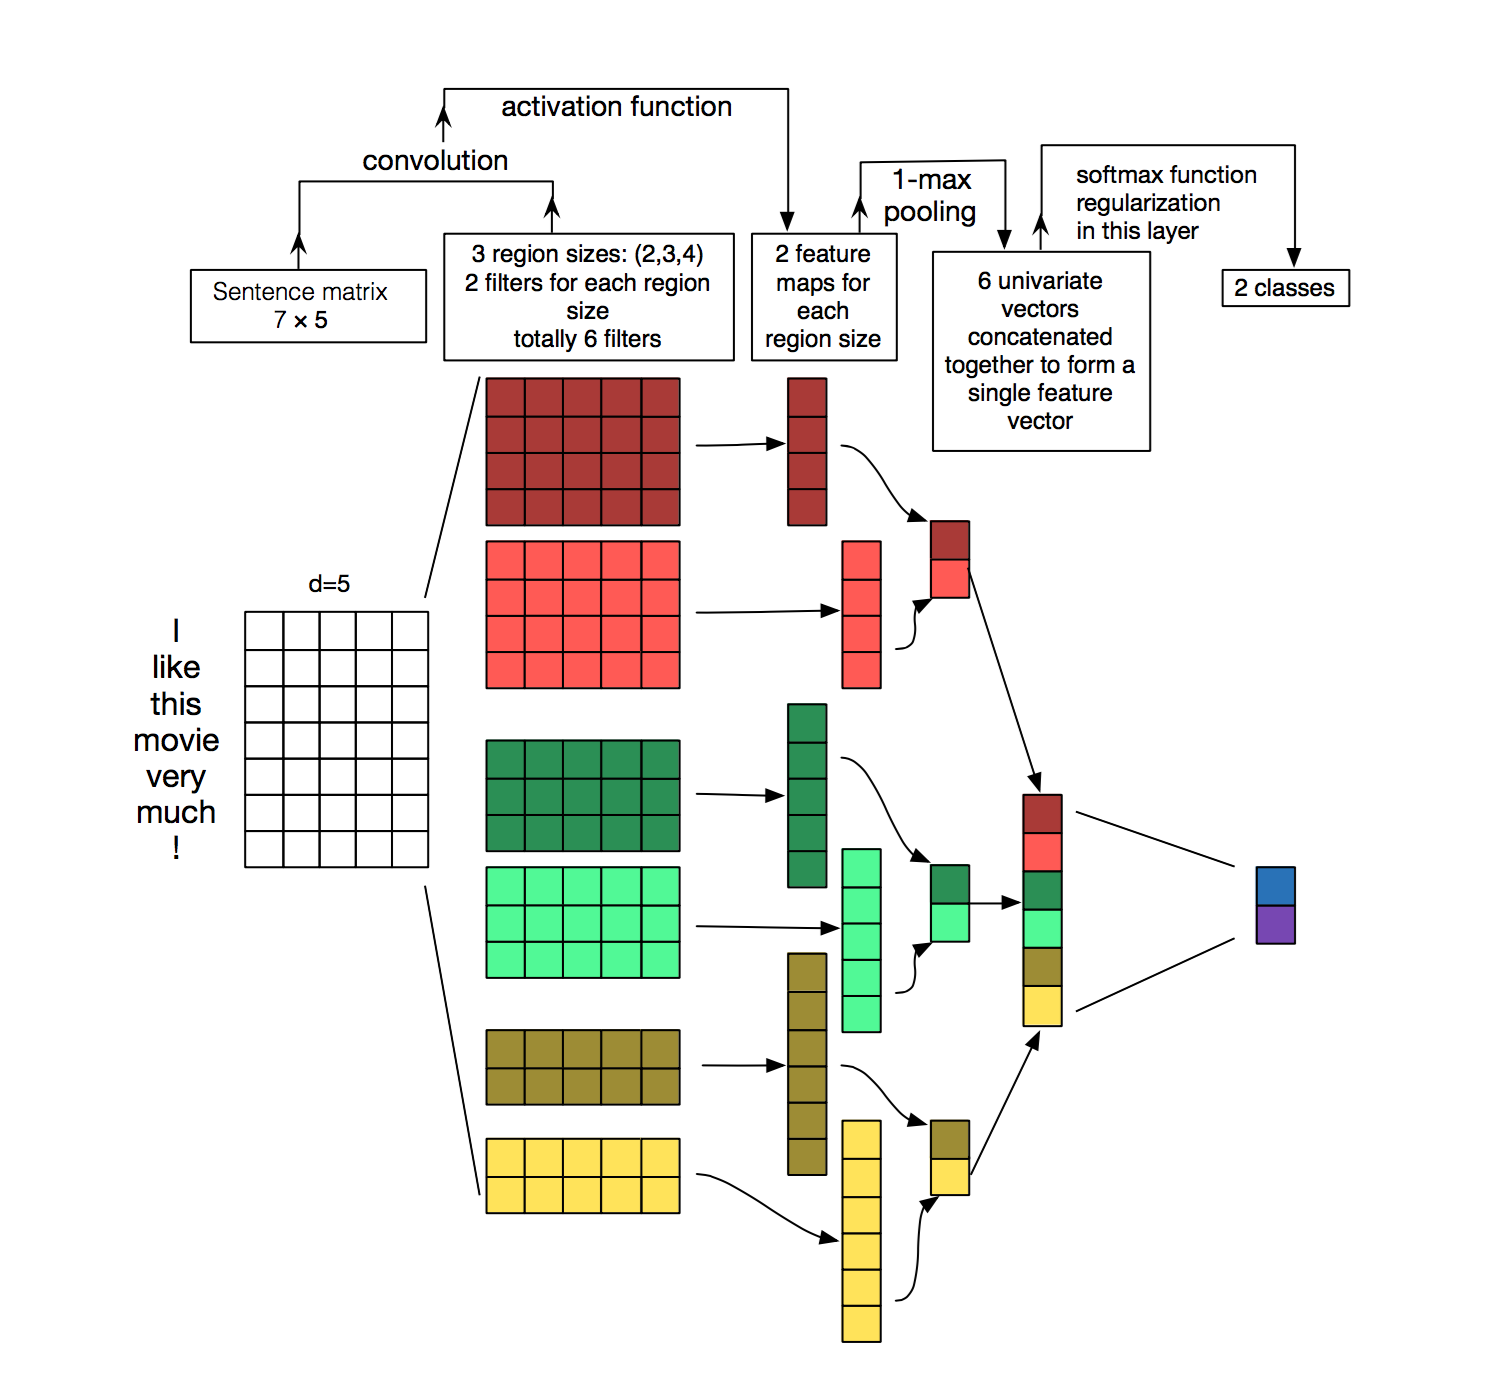

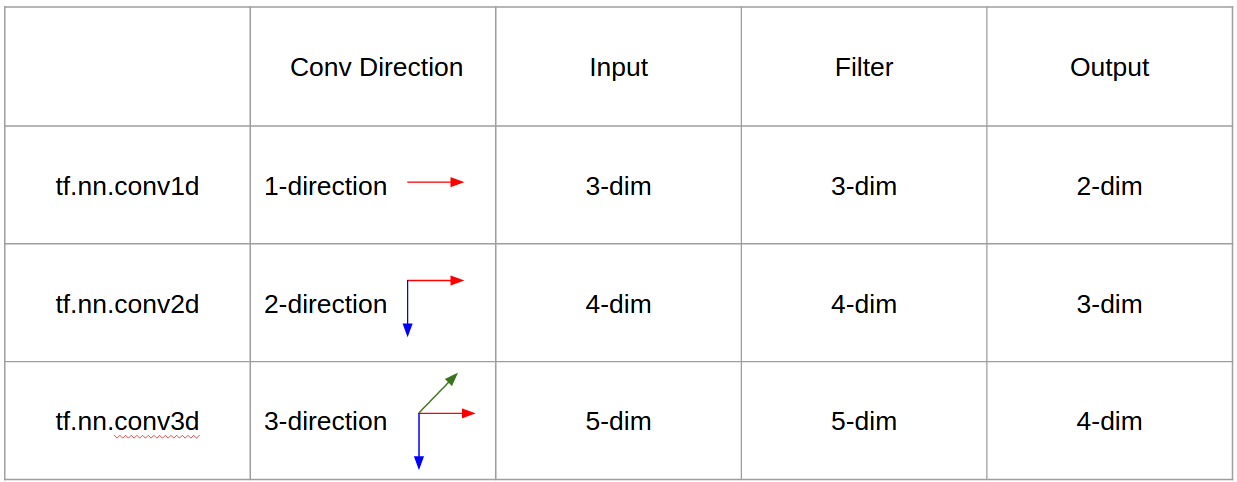

[Немного анимации](https://github.com/jerpint/cnn-cheatsheet)

### Данные & предобработка

In [ ]:
base_url = "https://github.com/madrugado/keras-tutorial/raw/master/data"
df_train = pd.read_csv(f"{base_url}/train.csv")
df_test = pd.read_csv(f"{base_url}/test.csv")
df_val = pd.read_csv(f"{base_url}/val.csv")

In [ ]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [ ]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [ ]:
train_corpus = list(df_train["text"])

In [ ]:
tokens = []

for text in tqdm(train_corpus):
  tokens.extend(word_tokenize(text))

tokens_filtered = [word for word in tokens if word.isalnum()]

  0%|          | 0/181467 [00:00<?, ?it/s]

In [ ]:
max_words = 2000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [ ]:
tokens_filtered_top[:10]

['не', 'и', 'я', 'в', 'RT', 'на', 'http', 'что', 'с', 'а']

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [ ]:
len(vocabulary)

1999

In [ ]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [ ]:
max_len = 40
x_train = np.array([text_to_sequence(text, max_len) for text in tqdm(df_train["text"])], dtype=np.int32)
x_test = np.array([text_to_sequence(text, max_len) for text in tqdm(df_test["text"])], dtype=np.int32)
x_val = np.array([text_to_sequence(text, max_len) for text in tqdm(df_val["text"])], dtype=np.int32)

  0%|          | 0/181467 [00:00<?, ?it/s]

  0%|          | 0/22684 [00:00<?, ?it/s]

  0%|          | 0/22683 [00:00<?, ?it/s]

In [ ]:
x_train.shape

(181467, 40)

In [ ]:
y_train = np.array(df_train["class"])
y_val = np.array(df_val["class"])

### Обучение модели CNN

In [ ]:
class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=32, out_channel=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1) # bs, emb_dim, len
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

**Note**: еще можно использовать несколько сверток разного размера


```python
self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, out_channel, kernel_size=k) for k in kernels])
self.linear = nn.Linear(len(kernels)*out_channel, num_classes)
```



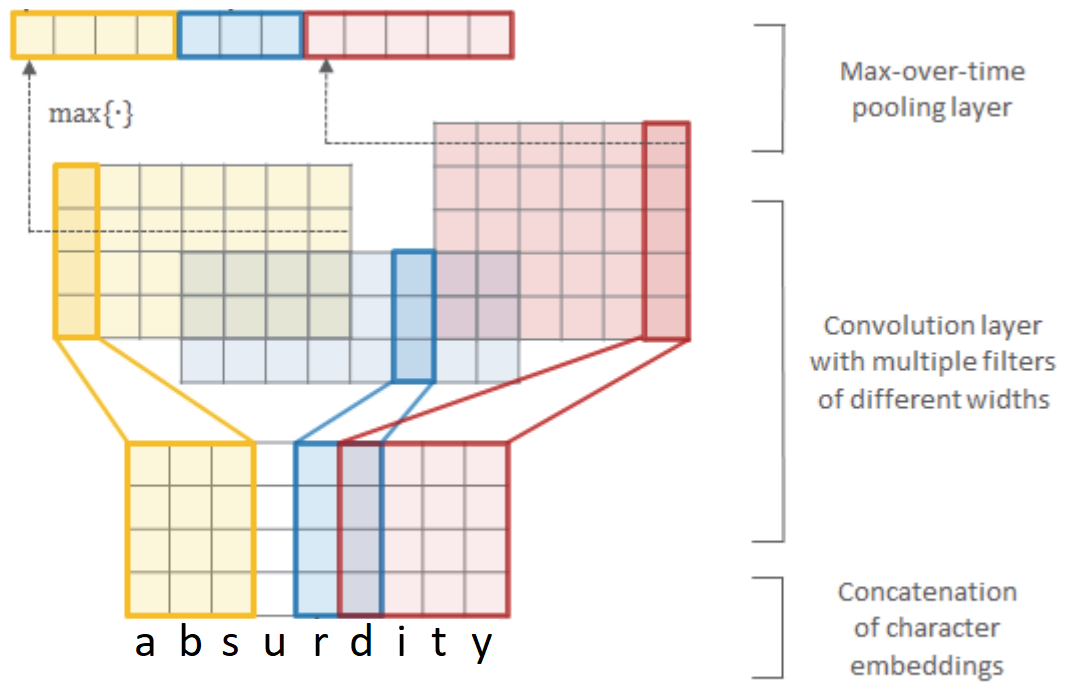

In [ ]:
class TextDataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
          self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
batch_size = 256
epochs = 10

model = ConvTextClassifier()
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
f1 = F1Score(task="binary")

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

train_dataset = TextDataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TextDataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1,epochs+1):
    print(f"Train epoch {epoch}/{epochs}")
    temp_loss = []
    temp_metrics = []

    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        temp_loss.append(loss.float().item())
        temp_metrics.append(f1(output.argmax(1), target).item())

    epoch_loss = np.array(temp_loss).mean()
    epoch_f1 = np.array(temp_metrics).mean()
    print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')

ConvTextClassifier(
  (embedding): Embedding(2000, 32)
  (conv): Conv1d(32, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 76674
Train epoch 1/10
Loss: 0.5946888322554456, f1 score: 0.679180405364071
Train epoch 2/10
Loss: 0.556856099363779, f1 score: 0.7173496858861786
Train epoch 3/10
Loss: 0.5409300439112277, f1 score: 0.7303395962345247
Train epoch 4/10
Loss: 0.5273395990282927, f1 score: 0.7406513939791574
Train epoch 5/10
Loss: 0.5126078910232431, f1 score: 0.7510923336355911
Train epoch 6/10
Loss: 0.49896731380010695, f1 score: 0.7603039596918103
Train epoch 7/10
Loss: 0.48492070280110045, f1 score: 0.7680880487889934
Train epoch 8/10
Loss: 0.4701573096310302, f1 score: 0.7761102078327508
Train epoch 9/10
Loss: 0.4584643795813088, f1 score: 0.7837605187183375
Train epoch 10/10
Loss: 0.44585406263220967, f1 score: 0.7897388916594017


## Рекуррентные нейронные сети

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/rnn_linear.png" width="600"></center>

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >
<tr>


<td>

$$\text{nn.Linear(in_features=3, out_features=2)}$$

</td>
<td>

$$\text{nn.RNN(input_size=3, hidden_size=2)}$$

</td>
<tr>


<td>

$$\large h = f_{\text{act}}(W_{xh}x)$$

</td>  
<td>

$$\large h_t = f_{\text{act}}(W_{hh}h_{t-1} + W_{xh}x_t)$$

</td>


</tr>

<td>

$$\large y = f_{\text{act}}(W_{hy}h)$$

</td>  

<td>

$$\large y_t = f_{\text{act}}(W_{hy}h_t)$$

</td>

</tr>


**Основная идея RNN-слоя**: подавать на вход слоя не только входные значения, но также и выход этого же слоя в предыдущий такт времени.

1) Вход слоя в текущий такт времени $\large x_t$ пропускается через свою матрицу линейного преобразования $\large W_{xh}$.

2) Выходы слоя с предыдущего такта времени $\large h_{t-1}$ пропускаются через свою матрицу линейного преобразования $\large W_{hh}$.

3) Значения складываются и пропускаются через функцию активации, формируя текущее скрытое состояние $\large h_t$. **В качестве функции активации рекуррентого слоя чаще всего используется гиперболический тангенс.**

Дополнительно скрытое состояние рекуррентного слоя может пропускаться **через обычный линейный слой** для формирования выходного значения $\large y_t$.

Обычно $\large h_0$ инициализируется нулями.


Вычисления в рекуррентной нейронной сети можно "развернуть во времени":

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/linear_to_rnn.png" width="1000"></center>

**Вектор $\large h_t$ содержит накопленный при просмотре предыдущих $\large t$ элементов последовательности контекст.**

Схему выше для компактности можно представить следующим образом, скомпоновав вектора $\large x_t$, $\large h_t$ и $\large y_t$.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/rnn_basic_block.png" width="1000"></center>


Рассмотрим работу рекуррентной нейронной сети при обработке последовательности:
1. На вход поступает некоторая последовательность $\large x = \{x_1,...x_t,...,x_T\}$, где $\large x_t$ — вектор фиксированной размерности. В ряде случаев этот вектор имеет размерность $1$.

2. Для каждого поступившего $\large x_t$ формируем скрытое состояние $\large h_t$, которое фактически является линейным преобразованием от предыдущего состояния $\large h_{t-1}$ и текущего элемента последовательности $\large x_t$, к которому применяется нелинейная функция активации:
$$\large h_t = f_{\text{act}}(W_{hh}h_{t-1} + W_{xh}x_t),$$
где $\large W_{hh}$ и $\large W_{xh}$  — это матрицы обучаемых параметров (веса). Также может добавляться вектор смещений (bias).

3. На основании рассчитанного скрытого состояния, учитывающего предыдущие значения  $\large x_t$, формируется выходная последовательность $\large y = \{y_1,...y_t,...,y_T\}$. Для формирования предсказания $\large y_t$ в текущий момент времени в модель добавляется обычный линейный слой, принимающий на вход текущее скрытое состояние $\large h_t$.

Обратим внимание, что рекуррентная формула для расчета скрытого состояния

$$\large h_t = f_{\text{act}}(W_{hh}h_{t-1} + W_{xh}x_t)$$

может быть представлена в виде $$\large h_t = f_{\text{act}}(W\ [h_{t-1},x_t]),$$

где $\large [h_{t-1},x_t]$ — конкатенация векторов $\large h_{t-1}$ и $\large x_t$, а $\large W$ — соответственно конкатенация матриц $\large W_{hh}$ и $\large W_{xh}$.

### RNN слой в PyTorch

В PyTorch есть слой — [`torch.nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), который реализует логику, описанную выше.

Также есть сущность [`torch.nn.RNNCell`](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html), которая реализует вычисления на одном такте времени.

Слой `nn.RNN` фактически является оберткой, которая вызывает `nn.RNNCell` в цикле по длине входной последовательности.


Техническая особенность рекуррентных слоев в PyTorch: по умолчанию ожидаемые размерности входа такие:

**`[длина последовательности, размер батча, размерность входа]`**

Однако если при создании слоя указать `batch_first=True`, то можно подавать входные значения в более привычном формате, когда размер батча стоит на первом месте:

**`[размер батча, длина последовательности, размерность входа]`**



In [ ]:
rnn = torch.nn.RNN(input_size=3, hidden_size=2, batch_first=True)

dummy_batched_seq = torch.randn((16, 57, 3))  # batch_size, seq_len, input_size
out, h = rnn(dummy_batched_seq)

print("Input shape:".ljust(20), f"{dummy_batched_seq.shape}")
print("Out shape:".ljust(20), f"{out.shape}")
print("Last hidden state shape:".ljust(20), f"{h.shape}")

Input shape:         torch.Size([16, 57, 3])
Out shape:           torch.Size([16, 57, 2])
Last hidden state shape: torch.Size([1, 16, 2])


При вызове слой возвращает два объекта:
* `out` — последовательность скрытых состояний,
* `h` — скрытое состояние на последнем такте.

Мы указали `batch_first=True`, при этом `out` сохранил последовательность размерностей как у входа, а вот у `h` размерность батча встала на второе место.

In [ ]:
h_batch_first = h.permute(1, 0, 2)

print(f"h is last out: {(h_batch_first == out[:, -1:, :]).all().item()}")

h is last out: True


### Многослойные RNN

RNN-блоки можно объединять в слои, накладывая их друг на друга. Для этой операции в `torch.nn.RNN` есть аргумент `num_layers`, с помощью которого можно указать количество слоёв.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/rnn_multiple_layers.png" width="500"></center>

In [ ]:
dummy_input = torch.randn((16, 6, 3))  # batch_size, seq_len, input_size
rnn = torch.nn.RNN(input_size=3, hidden_size=2, num_layers=2, batch_first=True)

out, h = rnn(dummy_input)

print()
print("Out:\n", out.shape)  # Hidden states for all elements from top layer
print("h:\n", h.shape)  # Hidden states for last element for all layers


Out:
 torch.Size([16, 6, 2])
h:
 torch.Size([2, 16, 2])


### Проблемы RNN

Теоретически, можно было бы сразу пропустить все данные через сеть и затем вычислить градиент, однако возникнут следующие проблемы:

 - большие последовательности не поместятся в памяти,
 - так как цепочка будет очень длинной, возникнет затухание/взрыв градиента,
 - по мере прохождения сигнала по цепи контекст затирается.


Допустим, у нас есть длинная последовательность. Если мы сразу предсказываем, то в каждый момент времени нужно распространить Loss. И все ячейки нужно обновить во время backpropogation. Все градиенты нужно посчитать. Возникают проблемы, связанные с нехваткой памяти.

Есть специальные тесты для проверки, контекст какой длины использует RNN при предсказании. Если мы делаем предсказание только в последней ячейке, может оказаться, что используется, скажем, информация только о последних 10 словах предложения.

Функция активации Tanh постепенно затирает контекст.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L09/backprop_through_time.png"><center>



Затухающий/взрывающийся градиент (Vanishing/exploding gradient) — явления затухающего и взрывающегося градиента часто встречаются в контексте RNN. И при большой длине последовательности это становится критичным. Причина в том, что зависимость величины градиента от числа слоёв экспоненциальная, поскольку веса умножаются многократно.

$dL ∝ (W)^N:$

$W > 1 \rightarrow$ взрыв, $W < 1 \rightarrow$ затухание.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/simple_rnn_backprop.png" width="1000">

Один из путей решения проблемы — **градиентное отсечение** (Gradient truncating) — метод, который ограничивает максимально допустимое значение градиента, позволяя избежать градиентного взрыва.

### LSTM (Long Short-Term Memory)

Обычная RNN имела множество проблем, в том числе в ней очень быстро затухала информация о предыдущих элементах последовательности. Помимо этого были проблемы с затуханием/взрывом градиента.

Эти проблемы были частично решены в LSTM, предложенной в [Long Short-Term Memory (Hochreiter & Schmidhuber, 1997)](http://www.bioinf.jku.at/publications/older/2604.pdf).

В обычной RNN-ячейке был только один путь передачи информации. На каждом шаге мы конкатенировали предыдущее скрытое состояние с текущим входом и пропускали их через линейный слой и активацию:

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >

<tr>
<td>

<center><img src = "https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/simple_rnn_h_state.png" width="500"></center>

</td>
<td>

<table >
<tr>
<td>

$\large h_t = \tanh(W \cdot [h_{t-1}, x_t])$

</td>

</tr>


</table>

</td>
</tr>

</table>








При этом информация о предыдущих элементах последовательности очень быстро затухает и теряется общая информация о предложении.

Структура ячейки LSTM намного сложнее. Здесь есть целых 4 линейных слоя, каждый из которых выполняет разные задачи.

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >
<tr>
<td>

<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/lstm_chain.png" width="500"></center>
<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/lstm_chain_notation.png" width="700"></center>

</td>
<td>

<table >
<tr>
<td>

$\large f_t = σ(W_f \cdot [h_{t-1}, x_t])\ \ \ \ $

</td>
<td>

$$\large \text{forget  gate}$$

</td>
</tr>

<tr>
<td>

$\large i_t = σ(W_i \cdot [h_{t-1}, x_t])$

</td>
<td>

$$\large \text{input gate}$$

</td>
</tr>

<tr>
<td>

$\large o_t = σ(W_o \cdot [h_{t-1}, x_t])$

</td>
<td>

$$\large \text{output gate}$$

</td>
</tr>

<tr>
<td>

$\large c^\prime_t = \tanh(W_c \cdot [h_{t-1}, x_t])$

</td>
<td>

$$\large \text{candidate cell state}$$

</td>
</tr>

<tr>
<td>

$\large c_t = f_t\otimes c_{t-1} + i_t \otimes c^\prime_t$

</td>
<td>

$$\large \text{cell state}$$

</td>
</tr>

<tr>
<td>

$\large h_t = o_t\otimes \tanh(c_t)$

</td>
<td>

$$\large  \text{hidden state}$$

</td>
</tr>
</table>

</td>
</tr>

</table>








Главное нововведение: в LSTM добавлен путь $c$, который по задумке должен этот общий контекст сохранять.

<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/lstm_c_state_highway.png" width="500"></center>

Другими словами, путь $c$ (cell state, иногда называется highway, магистраль)  помогает нейросети сохранять важную информацию, встретившуюся в какой-то момент в последовательности в прошлом, все время, пока эта информация требуется.

По формулам также видно, как возросла сложность.

### GRU (Gated Recurrent Unit)

Самая известная модификация LSTM — GRU. Она более компактна за счет сильных упрощений в сравнении со стандартной LSTM.

Главные изменения: объединены forget и input gates, слиты $h_t$ и $c_t$, которые в обычной LSTM только участвовали в формировании друг друга.

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >
<tr>
<td>

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L09/out/gru_basic_block.png" width="500"></center>

</td>
<td>

<table >
<tr>
<td>

$\large z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$

</td>

</tr>

<tr>
<td>

$\large r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$

</td>

</tr>

<tr>
<td>

$\large \tilde h_t = \tanh(W \cdot [r_t \otimes h_{t-1}, x_t])$

</td>

</tr>

<tr>
<td>

$\large h_t = (1-z_t) \otimes h_{t-1} + z_t \otimes \tilde h_t$

</td>


</table>








</td>
</tr>

</table>








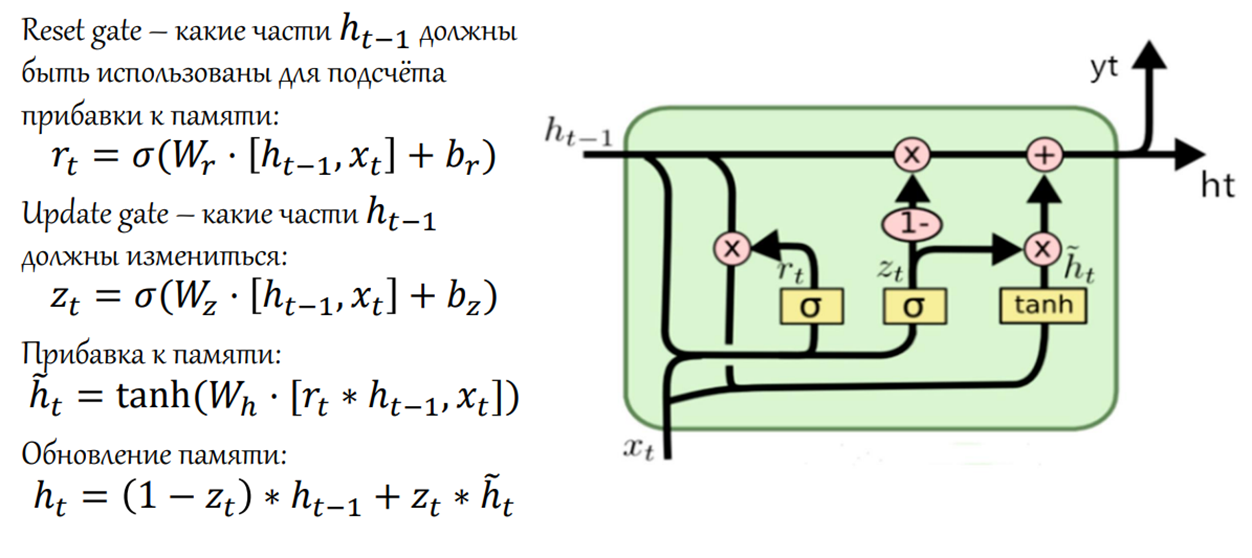

**Несколько фактов о GRU & LSTM**

- У GRU меньше параметров, и она более вычислительно эффективна

- Много данных → LSTM обычно показывает результаты чуть лучше

- Мало данных → GRU обычно показывает результаты чуть лучше

- Однозначно сказать нельзя, кто лучше

### Обучение модели LSTM

In [ ]:
class LSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=32, hidden_size=32, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.linear(output[:, -1, :])
        return output

In [ ]:
model = LSTMTextClassifier()
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
f1 = F1Score(task="binary")

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)

loss_history = []

for epoch in range(1,epochs+1):
    print(f"Train epoch {epoch}/{epochs}")
    temp_loss = []
    temp_metrics = []

    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        temp_loss.append(loss.float().item())
        temp_metrics.append(f1(output.argmax(1), target).item())

    epoch_loss = np.array(temp_loss).mean()
    epoch_f1 = np.array(temp_metrics).mean()
    print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')

LSTMTextClassifier(
  (embedding): Embedding(2000, 32)
  (lstm): LSTM(32, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
)
Parameters: 72514
Train epoch 1/10
Loss: 0.5824934549745283, f1 score: 0.6913854022666664
Train epoch 2/10
Loss: 0.5435985016553795, f1 score: 0.72718810202877
Train epoch 3/10
Loss: 0.5272203164309137, f1 score: 0.7395345133181519
Train epoch 4/10
Loss: 0.5138552516740872, f1 score: 0.747921453796758
Train epoch 5/10
Loss: 0.502085557861624, f1 score: 0.756008359962189
Train epoch 6/10
Loss: 0.49084859863659225, f1 score: 0.7621062556846522
Train epoch 7/10
Loss: 0.4820161077216247, f1 score: 0.7678647111097747
Train epoch 8/10
Loss: 0.4747067744119884, f1 score: 0.7720858579125828
Train epoch 9/10
Loss: 0.46740268126697565, f1 score: 0.7774277986020732
Train epoch 10/10
Loss: 0.4650351772943908, f1 score: 0.7784327515762178
